# Data analysis for $\mu = 0.4$ 65file(02.000exp) order Name

The code reads in the data from the associated .xlsx files, which contains information on:
- the number of photons produced
- the number of individual events
- the estimated probability distribution (after post-selecting on click events)

The code then runs the finite analysis SDP with a confidence parameter $\epsilon$, in order to find out how much randomness can be certified.

In [1]:
tic

S = dir('(*.xlsx');
nfiles = length(S);

epsi = 1E-9;
xs = 5;

Pg = zeros(1,nfiles);
Hmin = zeros(1,nfiles);

for i = 1:nfiles
    S(i).name;
    data = xlsread(S(i).name);
    
    nax = data(1:5,1:10)';
    mu = str2num(regexp(S(i).name,'(?<=_mi).+(?=_.xlsx$)','once','match'));
    xiax = nax./(ones(10,1)*sum(nax,1));
    
    
    p0 = 0; % we assume postselection
    p1 = exp(-mu)*mu;
    p2 = exp(-mu)*mu^2/2;

    psum = p0 + p1 + p2;

    p0 = p0/psum;
    p1 = p1/psum;
    p2 = p2/psum;

    d = 15;
    kets = eye(d);
    omegax = zeros(d,d,5);

    omegax(:,:,1) = p0*kets(:,1)*kets(1,:) + p1*kets(:,2)*kets(2,:) + p2*kets(:,6)*kets(6,:);
    omegax(:,:,2) = p0*kets(:,1)*kets(1,:) + p1*kets(:,3)*kets(3,:) + p2*kets(:,7)*kets(7,:);
    omegax(:,:,3) = p0*kets(:,1)*kets(1,:) + p1*kets(:,4)*kets(4,:) + p2*kets(:,8)*kets(8,:);
    omegax(:,:,4) = p0*kets(:,1)*kets(1,:) + p1*kets(:,5)*kets(5,:) + p2*kets(:,9)*kets(9,:);

    chi = 1/2*(kets(:,2) - kets(:,3) + kets(:,4) + kets(:,5));
    chi2 = (kets(:,6) + kets(:,7) + kets(:,8) + kets(:,9) +2*kets(:,15)...
            -2*kets(:,14)+2*kets(:,13)-2*kets(:,12)+2*kets(:,11)-2*kets(:,10));
    chi2 = chi2/sqrt(trace(chi2*chi2'));

    omegax(:,:,5) = p0*kets(:,1)*kets(1,:) + p1*chi*chi' + p2*chi2*chi2';
    
    [oa,ma] = size(xiax);

    cvx_begin sdp quiet

        variable Nae(d,d,oa,oa) hermitian semidefinite
        variable qe(oa)
        variable Pax(oa,ma)
      
        maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
            permute(repmat(eye(oa),[1,1,d,d]),[3,4,1,2])))
    
        for a = 1:oa-1
            for x = 1:ma
                xiax(a,x) - sqrt(log(1/epsi)/2/sum(nax(:,x))) <= trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x))
                trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x)) <= xiax(a,x) + sqrt(log(1/epsi)/2/sum(nax(:,x))) 
            end
        end
    
    
        for e = 1:oa 
            sum(Nae(:,:,:,e),3) == qe(e)*eye(d)
        end
    
        sum(qe) == 1
    
    cvx_end

    Pg(i) = cvx_optval;
    Hmin(i) = -log2(cvx_optval);

end

Hmin

toc

Hmin =
  Columns 1 through 7
    1.1261    1.0933    1.1200    1.0513    1.0568    1.1012    1.0511
  Columns 8 through 14
    1.0488    1.0752    1.0923    1.0977    1.0667    1.0329    1.0346
  Columns 15 through 21
    1.0396    1.0311    1.1216    1.1438    1.1480    1.0229    1.0379
  Columns 22 through 28
    1.0455    1.0715    1.1037    1.0738    1.0661    1.0893    1.0912
  Columns 29 through 35
    1.0901    1.0254    1.0716    1.0759    1.0255    1.0655    1.0881
  Columns 36 through 42
    1.1110    1.0215    1.0604    1.0822    1.0299    1.0473    1.0675
  Columns 43 through 49
    1.0334    1.0526    1.0720    1.0803    1.0206    1.0750    1.0764
  Columns 50 through 56
    1.0770    1.0484    1.0546    1.0578    1.0689    1.0235    1.0477
  Columns 57 through 63
    1.0921    1.1034    1.0553    1.0839    1.0478    1.0804    1.0786
  Columns 64 through 65
    1.0585    1.0717
Elapsed time is 206.342010 seconds.


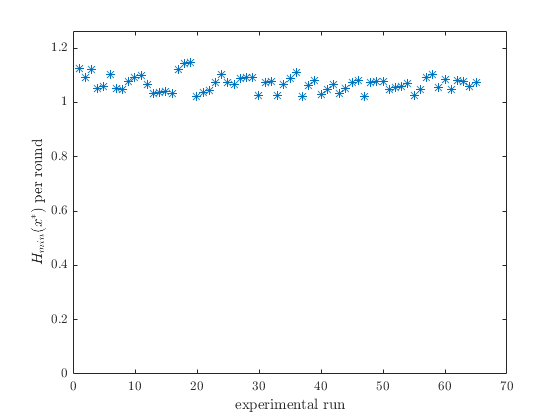

In [2]:
plot(Hmin,'*')
ylim([0 1.1*max(Hmin)])
xlabel('experimental run')
ylabel('$H_{min}(x^*)$ per round')

In [3]:
[min(Hmin) max(Hmin)]

ans =
    1.0206    1.1480
